<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Tarea 2 - Código Base</h2>
    <h2> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.00</h2>
</center>

# Contexto

Históricamente, varios videojuegos han explorado la idea de generar contenido automáticamente. Por ejemplo, Minecraft puede generar mundos aleatorios a explorar. Por otro lado, **Rogue, videojuego de mazmorras de 1980, genera sus mapas de manera procedural, e inspiró todo un género de videojuegos llamado _roguelike_ (similar a Rogue).**

![Rogue](img/rogue.png)

<div align="center">
Figura 1. Mazmorra generada automáticamente en el juego <i>Rogue</i>.
</div>

**Para la tarea 2, considere que usted es parte de una empresa de videojuegos, y ustedes quieren crear un nuevo juego _roguelike_. Pero necesitan ayuda para generar mazmorras de manera aleatoria, y usted es la persona indicada para resolver el problema.**

**Su primer avance consiste en generar las habitaciones individuales de las mazmorras.** En esta ocasión no es importante distribuir estas habitaciones apropiadamente en un mapa, crear puertas y caminos, etc.

Investigando sobre el tema, una buena forma de generar nuevas habitaciones es **interpolando _linealmente_ habitaciones ya existentes** mediante un **“análisis de las componentes principales” (PCA) de las habitaciones**.

![Interpolation](img/interpolation.png)

<div align="center">
Figura 2. Interpolación entre dos habitaciones creadas por humanos. 
Las habitaciones en los extremos son creadas por humanos, mientras que las habitaciones entre medio representan estados intermedios equiespaciados con una interpolación lineal convexa. 
Imagen extraída del paper <a href="https://proceduraldoctoratelabyrinth.files.wordpress.com/2014/11/sampling-hyrule-sampling.pdf"><i>Sampling Hyrule: Sampling Probabilistic Machine Learning for Level Generation</i></a>.
</div>

Dado un conjunto de datos, organizados como filas en una matriz, PCA es una técnica para expresar cada dato (o vector fila de la matriz de datos) como una combinación lineal de sus **“componentes principales”**: los vectores que aportan en mayor medida a la variación entre estos datos.
Usualmente, esto se hace para reducir la dimensionalidad de los datos y así comprimirlos en una representación de bajo consumo de memoria RAM, conservando solo las proyecciones sobre las componentes principales más importantes y descartando las demás.
**Al descartar las componentes menos importantes, hay pérdida de información, por lo que se debe buscar una cantidad adecuada de componentes para mantener un equilibrio entre una representación lo suficientemente fiel de los datos originales, y una buena compresión de estos.**

En este caso, usted necesita encontrar las **componentes principales** con los que se puede generar cada habitación, así como los **coeficientes** que participan en la reconstrucción.
Si se varían estos coeficientes, es decir, si se varía la cantidad a utilizar de cada componente principal, se generan nuevas habitaciones.
**La idea es tomar los vectores de coeficientes de dos habitaciones distintas, e interpolarlos linealmente _de forma convexa_ para generar una habitación intermedia entre estas dos.**

Usted ya tiene algo de código implementado para leer un dataset y dibujar la imagen de una habitación, así que es hora de resolver este problema. 
**¡Pero rápido, que hoy a las 18:00 hrs tiene una reunión con su equipo donde debe entregar sus avances!**

<div class="alert alert-block alert-info">Las habitaciones fueron adaptadas del primer juego de <i>The Legend of Zelda</i>. Todas las mazmorras (dungeons) están disponibles en esta página: <a href=https://zelda.fandom.com/wiki/Dungeons_in_The_Legend_of_Zelda>https://zelda.fandom.com/wiki/Dungeons_in_The_Legend_of_Zelda</a></div>

<div class="alert alert-block alert-info"><ul><li>El piso y la pared fueron obtenidos del tileset <i>Top-Down Dungeon Tileset</i>, de Enjl: <a href=https://enjl.itch.io/tileset-top-down-dungeon>https://enjl.itch.io/tileset-top-down-dungeon</a>
<li>El enemigo fue obtenido del tileset <i>16x16 DungeonTileset II</i>, de 0x72: <a href=https://0x72.itch.io/dungeontileset-ii>https://0x72.itch.io/dungeontileset-ii</a>
<li>La moneda fue obtenida del tileset <i>2D Pixel Dungeon Asset Pack</i>, de Pixel_Poem: <a href=https://pixel-poem.itch.io/dungeon-assetpuck>https://pixel-poem.itch.io/dungeon-assetpuck</a></ul><br/>Todos estos tilesets se encuentran gratis en <a href=https://itch.io>https://itch.io</a>.</div>

## Librerías, variables y funciones predefinidas (NO MODIFICAR)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
WIDTH = 12
HEIGHT = 10

In [3]:
def read_dataset(filename):
    """
    Parameters
    ----------
    filename:   string
                name of the text file to read (room_dataset.txt)
    ----------
    Returns
    DATASET:    ndarray
                matrix of rooms with the numbers 0, 1, 2 and 3
    """
    DATASET = np.empty((0, WIDTH*HEIGHT), dtype=int)
    
    with open(filename) as file:
        room = np.empty((HEIGHT, WIDTH), dtype=int)
        i = 0

        for line in file:
            line = line.strip()
            if line == '':
                continue

            line = line.strip()
            room[i] = np.array(list(map(int, list(line))))
            i += 1
            if i == HEIGHT:
                block = np.empty((4, WIDTH*HEIGHT), dtype=int)
                block[0] = room.flatten()
                block[1] = np.flip(room, 0).flatten() # Reflejar en el eje Y
                block[2] = np.flip(room, 1).flatten() # Reflejar en el eje X
                block[3] = block[0, ::-1] # Rotar en 180 grados
                DATASET = np.concatenate((DATASET, block))
                room = np.empty((HEIGHT, WIDTH), dtype=int)
                i = 0
                
    return DATASET

In [4]:
tiles = {}
for tile_name in ('floor', 'wall', 'enemy', 'coin'):
    tiles[tile_name] = Image.open(f'img/{tile_name}.png').convert('RGBA')
    tiles[tile_name].load()
    
def room_to_image(room):
    """
    Parameters
    ----------
    room:   ndarray
            matrix representing a room with the numbers 0, 1, 2 and 3
    ----------
    Returns
    canvas: Image
            image of the room
    """
    assert room.shape == (HEIGHT, WIDTH)
    
    canvas = Image.new('RGBA', (16*WIDTH, 16*HEIGHT))
    
    for i in range(WIDTH):
        for j in range(HEIGHT):
            canvas.paste(tiles['floor'], (i*16, j*16))

    for tile_number, tile_name in ((2, 'enemy'), (3, 'coin'), (1, 'wall')):
        J, I = np.nonzero(room == tile_number)
        for x in range(I.size):
            canvas.alpha_composite(tiles[tile_name], (I[x]*16, J[x]*16))
            
    canvas = canvas.resize((2*16*WIDTH, 2*16*HEIGHT), resample=Image.Resampling.BOX)
    return canvas

In [5]:
def split_dataset(DATASET):
    """
    Parameters
    ----------
    DATASET:    ndarray
                matrix of rooms with the numbers 0, 1, 2 and 3
    ----------
    Returns
    WALLS:      ndarray
                matrix of walls
    ENEMIES:    ndarray
                matrix of enemies
    COINS:      ndarray
                matrix of coins
    """
    WALLS = np.where(DATASET == 1, 1, 0) # en donde DATASET es 1 colocar un 1, y donde no lo es, colocar un 0
    ENEMIES = np.where(DATASET == 2, 1, 0) # ídem
    COINS = np.where(DATASET == 3, 1, 0) # ídem
    
    return WALLS, ENEMIES, COINS

In [6]:
def join_distributions(wall_row, enemy_row, coin_row):
    """
    Parameters
    ----------
    wall_row:   ndarray
                1D array representing a wall distribution
    enemy_row:  ndarray
                1D array representing an enemy distribution
    coin_row:   ndarray
                1D array representing a coin distribution
    ----------
    Returns
    room_row:   ndarray
                1D array representing a room with the numbers 0, 1, 2 and 3
    """
    room_row = np.zeros(HEIGHT*WIDTH, dtype=int)
    room_row[enemy_row == 1] = 2
    room_row[coin_row == 1] = 3
    room_row[wall_row == 1] = 1
    
    return room_row

## PROBLEMA 1. Exploración de datos (total: 5 puntos)

En el archivo *room_dataset.txt* hay varias representaciones de habitaciones de **12 casillas de ancho y 10 de alto**. Su formato es similar a este:
```
000000002000
011100301110
010020020010
010111111010
010111111010
010111111010
010111111010
010000000010
011100001110
000000000000
```
donde $0$ representa una casilla vacía (piso), $1$ representa una pared, $2$ un enemigo y $3$ una moneda.

La función $\verb|read_dataset|$ lee el archivo *room_dataset.txt*. Para poder manejar todo el volumen de información, **cada habitación se transforma en un vector fila de $12 \cdot 10 = 120$ componentes, y todos los vectores se apilan en una matriz de NumPy, denominada $\verb|DATASET|$**.

Además, para aumentar el tamaño del dataset, cada habitación se refleja vertical y horizontalmente, y se rota en 180°; con ello el tamaño de la base de datos aumenta en un factor de 4.

Reiterando: **cada fila en $\verb|DATASET|$ representa una habitación completa.**

In [7]:
# No olvidar ejecutar este código
DATASET = read_dataset('room_dataset.txt')

### Pregunta 1 (5 puntos)

La función $\verb|room_to_image|$, implementada más arriba, **dibuja una imagen de una habitación**. La habitación debe estar representada por una matriz de 10 filas y 12 columnas. 
Sin embargo, las habitaciones en $\verb|DATASET|$ están en forma de fila. 
Para poder dibujar una habitación con $\verb|room_to_image|$ se requiere convertir esa fila a una matriz con el tamaño apropiado.

Implemente la función $\verb|vector_to_room|$ que realiza esa tarea de forma vectorizada. **Necesitará esta función en el resto de esta tarea.**

Luego, use las funciones mencionadas para dibujar la 1° habitación de $\verb|DATASET|$.

In [8]:
def vector_to_room(vector):
    """
    Parameters
    ----------
    vector    :ndarray
               row in the DATASET
    Returns
    -------
    room   :ndarray
            matrix representing the room
    """
    # Escriba su solución aquí
    room = vector.reshape((10,12))
    return room

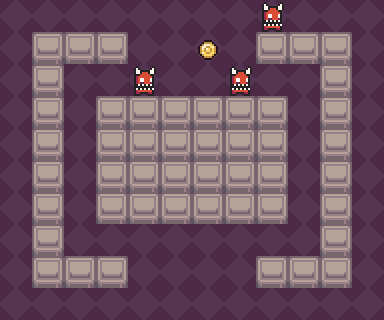

In [9]:
# Código para dibujar la 1° habitación
room_1 = vector_to_room(DATASET[0])
room_to_image(room_1)

## PROBLEMA 2. Análisis de distribuciones de paredes, enemigos y monedas (total: 55 puntos)
En esta parte se debe **analizar por separado las distribuciones de paredes, enemigos y monedas en las habitaciones**.
Es decir, se separará $\verb|DATASET|$ en tres matrices distintas, que luego se pueden volver a unir para reconstruir la matriz original.

Para cada una de las matrices, la idea es encontrar la _receta_ para generar una nueva distribución espacial de paredes/enemigos/monedas, es decir, encontrar las **componentes principales** de cada conjunto de datos, y los correspondientes **coeficientes** proyectados sobre las componentes principales de cada caso (paredes, enemigos o monedas).

Con esta información se podrá generar nuevas habitaciones más adelante.

### Pregunta 2.1 (5 puntos)
Use la función $\verb|split_dataset|$, ya implementada al inicio del archivo, para separar $\verb|DATASET|$ en tres **matrices de distribuciones**: una matriz con las paredes ($\verb|WALLS|$), una con los enemigos ($\verb|ENEMIES|$), y una con las monedas ($\verb|COINS|$).

<div class="alert alert-block alert-info"><b>Una distribución es la manera en que se reparten las paredes, enemigos o monedas en una habitación.</b><br/>
<b>Las 3 matrices WALLS, ENEMIES y COINS son binarias, es decir, sus coeficientes pertenecen al conjunto {0, 1}.</b>
Por ejemplo, la matriz de distribución de enemigos (ENEMIES) contiene un 1 en las posiciones donde hay enemigos, y un 0 donde no los hay.
Ídem con la matriz de distribución de paredes (WALLS) y la de monedas (COINS). <br/>
<b>Cada fila de la matriz WALLS representa una distribución de paredes para la habitación correspondiente, y lo mismo con ENEMIES y COINS.</b>
</div>

Luego use $\verb|plt.imshow|$ para graficar la distribución de paredes de la 1° habitación. Recuerde que el arreglo que representa la habitación debe tener la forma apropiada.

In [10]:
# Código para definir WALLS, ENEMIES y COINS
WALLS, ENEMIES, COINS = split_dataset(DATASET)

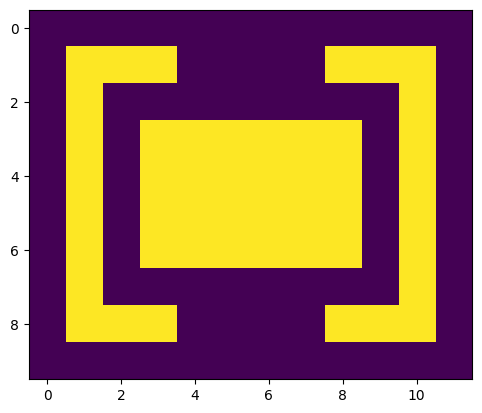

In [11]:
# Código para inspeccionar la distribución de paredes de la 1° habitación
plt.imshow(vector_to_room(WALLS[0]))

### Pregunta 2.2 (20 puntos)
Ahora se debe realizar PCA a cada matriz de distribuciones por separado (paredes, enemigos, monedas), para encontrar características comunes en cada una.

Implemente la función $\verb|PCA|$, que debe recibir como parámetros:
- una matriz $M$ de distribuciones generada en 2.1
- la cantidad $m$ de componentes principales a obtener

La función $\verb|PCA|$ debe descomponer la matriz en tres matrices:
- $V$, que contiene las $m$ componentes principales de la matriz $M$
- $Y$, matriz de coeficientes para generar cada una de las filas (distribuciones) de la matriz original $M$
- $\mu$, arreglo de NumPy de medias de cada columna de $M$

<div class="alert alert-block alert-danger"><b>Está prohibido usar funciones ya prefabricadas como sklearn.decomposition.PCA para implementar la función PCA.</b>
</div>

<div class="alert alert-block alert-info">En su implementación debe usar la función np.linalg.svd. <b>¡La SVD debe ser reducida!</b> Revise la documentación para saber más detalles: <a href=https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html>https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html</a>
</div>



In [12]:
def PCA(M, m):
    """
    Parameters
    ----------
    M         :ndarray
               matrix from 2.1
    m         :int
               amount of principal components to keep
    Returns
    -------
    V         :ndarray
               Matrix of first m principal components
    Y         :ndarray
               Matrix of principal component coefficients
    mu        :ndarray
               1D array of averages per column of M
    """
    # Escriba su código acá
    #center data
    mu = M.mean(axis=0) 
    
    m_M, n_M = M.shape
    
    #print(f"mxn de M: {m_M}, {n_M}")
    #print(f"shape de mu: {mu.shape}")

    ones = mu
    
    Z = M - mu
    
    #svd
    U, S, VT = np.linalg.svd(Z, full_matrices=False)
    
    V = VT.T
    V = V[:,:m]
    
    Y = Z @ V
    
    return V, Y, mu

### Pregunta 2.3 (5 puntos)
Ahora realice un PCA de 32 componentes sobre la matriz de distribuciones de paredes.

Luego, obtenga la 1° componente principal y muéstrela con $\verb|plt.imshow|$.

In [13]:
# PCA sobre WALLS
V, Y, mu = PCA(WALLS, 32)

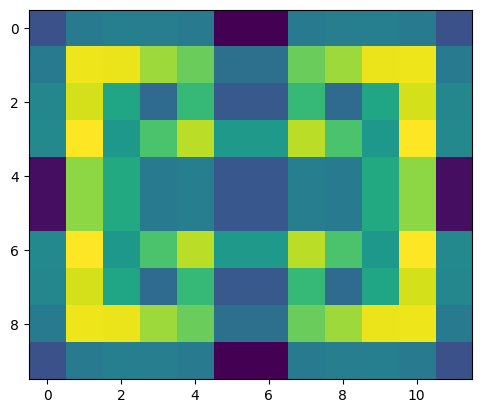

In [14]:
# Graficar 1° componente principal de WALLS
plt.imshow(vector_to_room(V[ :,0]))

### Pregunta 2.4 (20 puntos)
Para verificar que todo salió bien, hace falta una implementación que reconstruya (usando las $m$ componentes seleccionadas previamente) cualquier fila de la matriz original $M$, que representa la distribución original correspondiente de paredes, enemigos o monedas.
Para ello se requieren las componentes principales y los coeficientes correspondientes a esa distribución.

Implemente la función $\verb|rebuild_ith_row|$, que debe reconstruir la fila $i$ (donde $i$ parte desde $0$) de la matriz cuyo PCA entregó anteriormente las matrices $V$, $Y$ y $\mu$.

Luego, reconstruya la distribución de paredes en la 1° habitación usando los resultados del PCA de la pregunta 2.3, y grafique el resultado con $\verb|plt.imshow|$.

In [15]:
def rebuild_ith_row(V, Y, mu, i):
    """
    Parameters
    ----------
    V         :ndarray
               Matrix of first m principal components
    Y         :ndarray
               Matrix of principal component coefficients
    mu        :ndarray
               1D array of averages per column of the original distribution matrix
    i         :int
               Index of row to rebuild
    Returns
    -------
    rebuilt_row:ndarray
                1D array of the i-th distribution of walls/enemies/coins
    """
    # Escriba su código acá
    ith_row_y = Y[i, :]
    rebuilt_row = (V @ ith_row_y.T) + mu
    return rebuilt_row

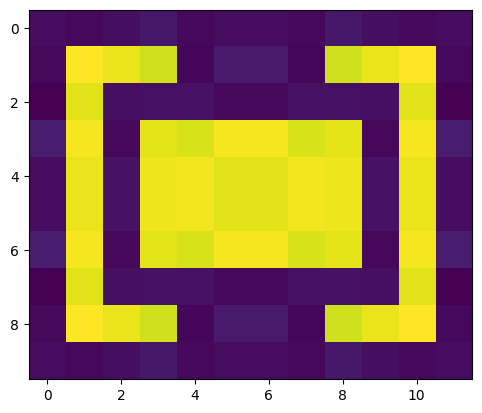

In [16]:
# Código para reconstruir paredes de 1° habitación y graficarlas
first_room = rebuild_ith_row(V, Y, mu, 0)
plt.imshow(vector_to_room(first_room))

### Pregunta 2.5 (5 puntos)
Como se puede notar en 2.4, el gráfico tiene ruido, lo cual es normal. 
Ahora las casillas toman varios valores numéricos almacenados con el estandar de punto flotante. 
Sin embargo, es necesario que el resultado final sea simplemente una matriz binaria, con solo $0$s y $1$s.

Implemente de forma vectorizada la función $\verb|binarize|$ que convierte un arreglo de flotantes en un arreglo de $0$s y $1$s.

Para confirmar que la función está bien implementada, aplique $\verb|binarize|$ sobre la reconstrucción anterior de la 1° distribución de paredes para corregir sus valores, y grafique el nuevo resultado.

<div class="alert alert-block alert-info">El arreglo que genera la función rebuild_ith_row podría contener valores fuera del rango [0, 1]. 
Al usar un simple redondeo al entero más cercano, ¿realmente se puede asegurar que cada valor se redondeará <b>siempre</b> a 0 o a 1?
</div>

In [17]:
def binarize(arr):
    """
    Parameters
    ----------
    arr       :ndarray
               1D-array or 2D-array with floats
    Returns
    -------
    binarized_arr:ndarray
                  1D-array or 2D-array with values 0 or 1
    """
    # Escriba su código acá
    #con esto covierte todo el array a enteros, por lo tanto los numero entre [0, 1] no necesitan mas alteraciones
    binarized_arr = np.around(arr, decimals=0, out=None)
    
    #ahora para valores fuera del rango [0,1]
    binarized_arr = np.where(binarized_arr > 1, 1, binarized_arr)
    binarized_arr = np.where(binarized_arr < 0, 0, binarized_arr)

    return binarized_arr

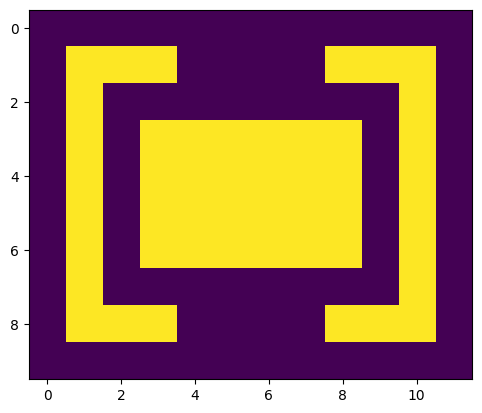

In [18]:
# Código para mostrar la reconstrucción corregida de las paredes de la 1° habitación
binarized_room = binarize(first_room)
plt.imshow(vector_to_room(binarized_room))

## PROBLEMA 3. Generación de nuevas habitaciones (total: 30 puntos)

El procedimiento para generar nuevos mapas de paredes/enemigos/monedas, es seleccionar 2 componentes principales, por ejemplo $i$ y $j$, e _interpolarlas_. 
Para ello se debe combinar dos vectores de coeficientes en $\verb|Y|$, que reconstruyen respectivamente la $i$-ésima fila y $j$-ésima fila de la matriz de distribuciones original.

Específicamente, sea $\alpha \in [0, 1]$, y sean $\mathbf{y}_i$ e $\mathbf{y}_j$ los vectores de coeficientes de las distribuciones $i$ y $j$ respectivamente. 
Se usará la siguiente combinación lineal convexa:

$$ \textbf{y}_{\text{nuevo}} = (1-\alpha)\,\textbf{y}_i + \alpha\,\textbf{y}_j $$

En particular, si $\alpha = 0$ se obtiene simplemente $\textbf{y}_i$. 
Si $\alpha = 1$ se obtiene $\textbf{y}_j$. 
Pero si $\alpha = 0.5$, se obtiene un punto medio entre $\textbf{y}_i$ e $\textbf{y}_j$.

Con estos vectores $\textbf{y}_{\text{nuevo}}$ se pueden generar nuevas distribuciones de paredes, enemigos y monedas. Finalmente, estas se pueden combinar en una nueva habitación con la función $\verb|join_distributions|$, definida al principio de este archivo.

### Pregunta 3.1 (10 puntos)
Implemente la función $\verb|interpolate_rows|$, que debe interpolar los coeficientes de dos distribuciones $i$ y $j$ en base a un $\alpha$, y luego usar los nuevos coeficientes para generar una nueva fila representando una nueva distribución.
La fila que retorne la función debe ser binaria, es decir, debe consistir solo de $0$s y $1$s.

In [19]:
def interpolate_rows(V, Y, mu, i, j, alpha):
    """
    Parameters
    ----------
    V         :ndarray
               First m principal components
    Y         :ndarray
               Principal Component Coefficients
    mu        :ndarray
               Average per column of M
    i         :int
               ith row to merge
    j         :int
               jth row to merge
    alpha     :float
               Merge amount
    Returns
    -------
    new_row:ndarray
            1D-array of the new row. It must be a binary array.
    """
    # Escriba su código aquí
    
    y_i = Y[i, :]
    y_j = Y[j, :]
    y_new = (1 - alpha)*y_i + alpha * y_j
    new_row = (V @ y_new.T) + mu
    binarized_new_row = binarize(new_row)
    new_row = binarized_new_row
    return new_row

### Pregunta 3.2 (2 puntos)
Usando el PCA realizado sobre la matriz de paredes en la pregunta 2.3, interpole las distribuciones de paredes de índice $i = 0$ y $j = 16$, con $\alpha = 0.5$.

Luego grafique el resultado con $\verb|plt.imshow|$.

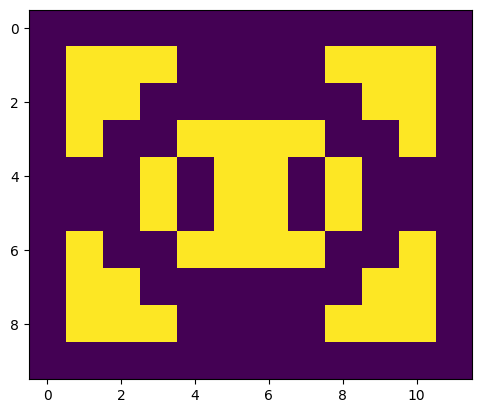

In [20]:
# Código para graficar la interpolación de paredes i=0 y j=16
new_room = interpolate_rows(V, Y, mu, 0, 16, 0.5)
plt.imshow(vector_to_room(new_room))

### Pregunta 3.3 (15 puntos)

Implemente la función $\verb|generate_new_room_row|$, que recibe tres matrices de distribuciones $\verb|WALLS|$, $\verb|ENEMIES|$ y $\verb|COINS|$, una cantidad $m$ de componentes principales a calcular, los índices $i$ y $j$ de las habitaciones a interpolar, y una constante de interpolación $\alpha$.

Esta función debe realizar un PCA sobre las tres matrices de distribuciones por separado, obteniendo $m$ componentes principales para cada una.

Con esta información, se debe interpolar las filas $i$ y $j$ de cada matriz con la constante $\alpha$, para generar una nueva distribución de habitaciones, una de enemigos y otra de monedas.

Finalmente, la función combina las tres distribuciones con $\verb|join_distributions|$ para retornar una fila que representa una nueva habitación.

In [21]:
def generate_new_room_row(WALLS, ENEMIES, COINS, m, i, j, alpha):
    """
    Parameters
    ----------
    WALLS  :ndarray
            matrix of walls
    ENEMIES:ndarray
            matrix of enemies
    COINS  :ndarray
            matrix of coins
    m      :int
            number of principal components
    i      :int
            index of first row to interpolate
    j      :int
            index of second row to interpolate
    alpha  :float
            interpolation constant
    ----------
    Returns
    new_room_row:ndarray
                 1-D array representing a room with the numbers 0, 1, 2 and 3
    """
    # Escriba su código aquí
    V_w, Y_w, mu_w = PCA(WALLS, m)
    new_walls = interpolate_rows(V_w, Y_w, mu_w, i, j, alpha)
    
    V_e, Y_e, mu_e = PCA(ENEMIES, m)
    new_enemies = interpolate_rows(V_e, Y_e, mu_e, i, j, alpha)
    
    V_c, Y_c, mu_c = PCA(COINS, m)
    new_coins = interpolate_rows(V_c, Y_c, mu_c, i, j, alpha)
    
    new_room_row = join_distributions(new_walls, new_enemies, new_coins)
    
    return new_room_row

### Pregunta 3.4 (3 puntos)
Use la función $\verb|generate_new_room_row|$ para generar la fila de una nueva habitación a partir de la 1° y 17° (índices 0 y 16 respectivamente), con 32 componentes principales y $\alpha = 0.5$.

Finalmente, dibuje el resultado con $\verb|room_to_image|$.

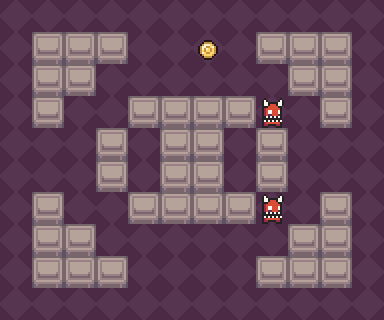

In [22]:
# Código para interpolar las habitaciones de índices 0 y 16
new_row = generate_new_room_row(WALLS, ENEMIES, COINS, 32, 0, 16, 0.5)
room_to_image(vector_to_room(new_row))

**¡Ya ha llegado al final de la tarea número 2! Ahora debe enviarla antes de las 18:00 hrs.**